
# Data Aggregation - Joe Iafrate, July 2017

In [3]:
# run using dev install of EDA:
# github.com/vsihlab/eda
# commit ID: [TODO, downstream from v0.1.1]

In [4]:
# General imports
import json
import pickle

from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

import eda.analysis.dataframe_plotting as dfplot
import eda.data_io.csv_to_dataframe as csv2df

In [5]:
# GLOBAL UNITS: 
# time: ps
# b-field: mT
# voltages: V

# FIGURE DIMENSIONS FOR PRIVATE USE VS REPO:
# FIG_SIZE_MULT = 4  # normal use
FIG_SIZE_MULT = 2.5  # smaller version for repo notebooks

FONT_SCALE = FIG_SIZE_MULT / 2.5

In [6]:
# Optional: import jtplot to make figures match jupyterthemes config
import importlib
jtplot_found = importlib.util.find_spec("jupyterthemes.jtplot") is not None
if jtplot_found:
    from jupyterthemes import jtplot
    # - currently installed theme will be used to
    jtplot.style(ticks=False, grid=False, fscale=FONT_SCALE)
    # set the default figure size
    jtplot.figsize(x=FIG_SIZE_MULT * 2.5, y=FIG_SIZE_MULT * 2.5)
    # needed to avoid spurious error messages with imshow...
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

## Load pre-processed data

### Load "july2017_assorted_data/Delay_Scan" (TRKR)

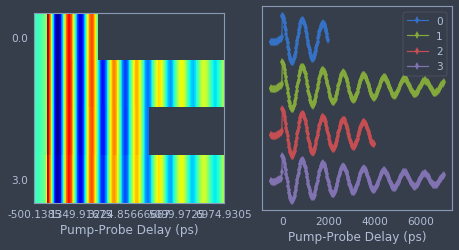

probe_delay   lockin1  kerr_rotation  file_index  \
run_id index_2d index_1d                                                     
0      0.0      0           -500.2216  0.000130       -0.02200           0   
                1           -475.2909  0.000122       -0.02742           0   
                2           -450.3601  0.000088       -0.03182           0   
                3           -425.4294  0.000033       -0.03474           0   
                4           -400.2216  0.000050       -0.03608           0   

                          b_external  wavelength  
run_id index_2d index_1d                          
0      0.0      0              200.0       836.0  
                1              200.0       836.0  
                2              200.0       836.0  
                3              200.0       836.0  
                4              200.0       836.0

...
PREPROCESSED FIT RESULTS:


file_index  b_external  wavelength  pulse_amplitude  \
run_id index_2d                                                        
0.0    0.0              0.0       200.0      836.00         0.386819   
       1.0              1.0       200.0      836.00         0.410003   
       2.0              2.0       200.0      836.00         0.408352   
       3.0              3.0       200.0      836.17         0.392691   

                 pulse_amplitude_error   gfactor  gfactor_error  \
run_id index_2d                                                   
0.0    0.0                    0.008851  0.405162       0.000924   
       1.0                    0.005446  0.404725       0.000278   
       2.0                    0.001084  0.404369       0.000084   
       3.0                    0.005408  0.405171       0.000289   

                 spin_lifetime  spin_lifetime_error  initial_phase  \
run_id index_2d                                                      
0.0    0.0         7517.226139           857.867390            0.0   
       1.0         4945.875900           120.927935            0.0   
       2.0         5039.222647            35.580412            0.0   
       3.0         4934.963889           124.821427            0.0   

                 extra_phase_offset  extra_phase_offset_error         slope  \
run_id index_2d                                                               
0.0    0.0                 0.059266                  0.025113 -8.937828e-06   
       1.0                 0.063383                  0.013178 -7.896465e-07   
       2.0                 0.064599                  0.002788 -1.221752e-07   
       3.0                 0.070988                  0.013674 -7.553231e-07   

                  slope_error    offset  offset_error  result_index    chisqr  \
run_id index_2d                                                                 
0.0    0.0       6.912700e-06  0.010000      0.007360             0  0.135051   
       1.0       6.317701e-07  0.006159      0.002477             1  0.162882   
       2.0       2.570474e-07  0.001602      0.000560             2  0.003116   
       3.0       6.272968e-07  0.006618      0.002459             3  0.160486   

                   redchi  
run_id index_2d            
0.0    0.0       0.001437  
       1.0       0.000554  
       2.0       0.000018  
       3.0       0.000546

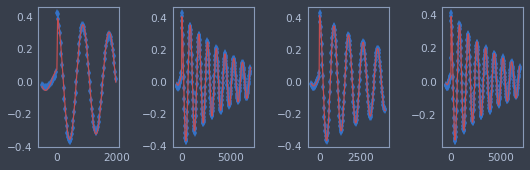

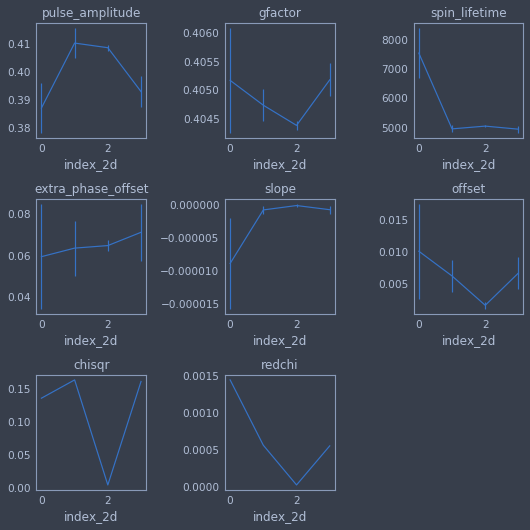

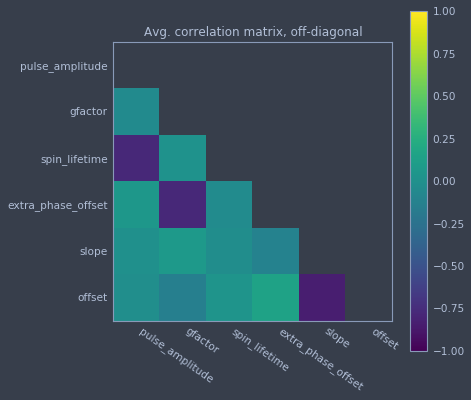

In [23]:
# REQUIRED: input filepaths
shared_filepath = ".//example_data//july2017_assorted_data//Delay_Scan//"
dataframe_filepath = \
    shared_filepath + "processed_dataframe.csv"
metadata_list_filepath = \
    shared_filepath + "processed_metadata_list.json"
fit_results_dataframe_filepath = \
    shared_filepath + "fit_results_dataframe.csv"
fit_minimize_results_filepath = \
    shared_filepath + "fit_minimize_results.pickle"

# REQUIRED FOR PRE-FIT DATA: fit function & residuals
from eda.analysis.fit_tools import create_residuals_fcn
from eda.models.simple_dnp_trkr_rsa_simulation \
    import trkr_decaying_cosine
trkr_fit_function = trkr_decaying_cosine
trkr_fit_function_residuals = \
    create_residuals_fcn(trkr_decaying_cosine,
                         ['delay_time', 'total_bfield'])

# load data
with open(dataframe_filepath, 'r') as f:
    trkr_df = pd.read_csv(f, sep='\t',
                          index_col=['run_id', 'index_2d',
                                     'index_1d'])
with open(fit_results_dataframe_filepath, 'r') as f:
    trkr_fit_df = pd.read_csv(f, sep='\t',
                              index_col=['run_id', 'index_2d'])
with open(metadata_list_filepath, 'r') as f:
    trkr_file_metadata_list = json.load(f)
with open(fit_minimize_results_filepath, 'rb') as f:
    trkr_minimize_results = pickle.load(f)

# plot loaded dataframe and show the first few rows
figure_size = (FIG_SIZE_MULT * 3, FIG_SIZE_MULT * 1.5)
num_waterfall_plots = 4
data_column = 'kerr_rotation'
x_values_column = 'probe_delay'
y_values_column = None
xlabel = 'Pump-Probe Delay (ps)'
ylabel = None
imshow_kwargs = {'aspect': 1.0,
                 'origin': 'upper'}
plt.figure(figsize=figure_size)
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
dfplot.plot_dataframe_colorplot(trkr_df, data_column,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=ylabel,
                                ax=ax1, **imshow_kwargs)
dfplot.plot_dataframe_waterfall(trkr_df, data_column,
                                num_waterfall_plots,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=None, ax=ax2)
ax2.yaxis.set_ticklabels([])
plt.show()
display(trkr_df.head(5))
print('...')
print('PREPROCESSED FIT RESULTS:')

# plot loaded fits
ncols = 4
nplots = len(trkr_minimize_results)
nrows = np.int(np.ceil(nplots / ncols))
display(trkr_fit_df.head(5))
plt.figure(figsize=(FIG_SIZE_MULT * 3, FIG_SIZE_MULT * nrows))
for result_index in list(range(nplots)):
    ax = plt.subplot(nrows, ncols, result_index + 1)
    result = trkr_minimize_results[result_index]
    dataset_index = trkr_fit_df.index[result_index]
    xvals = trkr_df.loc[dataset_index][x_values_column]
    yvals = trkr_df.loc[dataset_index][data_column]
    fit_yvals = trkr_fit_function_residuals(
                    result.params,
                    trkr_df.loc[dataset_index].probe_delay,
                    trkr_df.loc[dataset_index].b_external)
    ax.plot(xvals, yvals, 'bd', label='dataset {}'.format(result_index))
    ax.plot(xvals, fit_yvals, 'r')
    plt.tight_layout()

# plot params
params_to_plot_list = \
    result.var_names + ['chisqr', 'redchi']
ncols = 3
nplots = len(params_to_plot_list)
nrows = np.int(np.ceil(nplots / ncols))
plt.figure(figsize=(FIG_SIZE_MULT * 3, FIG_SIZE_MULT * nrows))
for ind, param in enumerate(params_to_plot_list):
    ax = plt.subplot(nrows, ncols, ind + 1)
    if (param + '_error') in list(trkr_fit_df):
        ax.errorbar(x=trkr_fit_df.index.get_level_values(-1),
                    y=trkr_fit_df[param],
                    yerr=trkr_fit_df[param + '_error'])
    else:
        ax.plot(trkr_fit_df.index.get_level_values(-1),
                trkr_fit_df[param].values)
    plt.xlabel(trkr_fit_df.index.names[-1])
    plt.tight_layout()
    plt.title(param)

# plot the avg. covariance matrix
corr_mats = []
for result in trkr_minimize_results:
    covar = result.covar
    oostd = np.diagflat([1.0 / param.stderr
                         for param in list(result.params.values())
                         if param.name in result.var_names])
    corr = np.dot(np.dot(oostd, result.covar), oostd)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    corr[mask] = np.nan
    corr_mats.append(corr)
avgcorr = np.mean(corr_mats, axis=0)
plt.figure()
plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(np.arange(result.nvarys), result.var_names,
           rotation=-35, ha='left')
plt.yticks(np.arange(result.nvarys), result.var_names)
plt.title('Avg. correlation matrix, off-diagonal')
plt.show()

### Load "july2017_assorted_data/Field_Scan" (RSA)

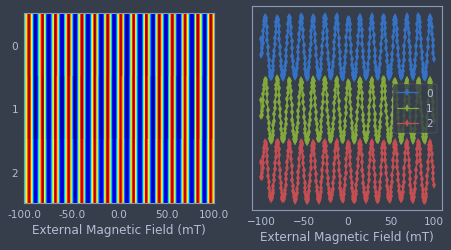

lockin1  kerr_rotation  file_index  probe_delay  \
run_id index_2d index_1d                                                     
0      0.0      0         0.000266        0.01572           0       -160.0   
                1         0.000213       -0.00434           0       -160.0   
                2         0.000274       -0.00180           0       -160.0   
                3         0.000351        0.00418           0       -160.0   
                4         0.000342        0.01082           0       -160.0   

                          wavelength  b_external  
run_id index_2d index_1d                          
0      0.0      0              836.0      -100.0  
                1              836.0       -99.5  
                2              836.0       -99.0  
                3              836.0       -98.5  
                4              836.0       -98.0

...
PREPROCESSED FIT RESULTS:


file_index  probe_delay  wavelength  pulse_amplitude  \
run_id index_2d                                                         
0.0    0.0              0.0       -160.0      836.00         0.478873   
       1.0              1.0       -160.0      836.00         0.483980   
       2.0              2.0       -160.0      836.17         0.458615   

                 pulse_amplitude_error   gfactor  gfactor_error  \
run_id index_2d                                                   
0.0    0.0                    0.004433  0.403224       0.000138   
       1.0                    0.004338  0.403326       0.000134   
       2.0                    0.004145  0.403692       0.000135   

                 spin_lifetime  initial_phase  extra_phase_offset  \
run_id index_2d                                                     
0.0    0.0              5000.0            0.0           -0.435138   
       1.0              5000.0            0.0           -0.416991   
       2.0              5000.0            0.0           -0.402817   

                 extra_phase_offset_error  slope    offset  offset_error  \
run_id index_2d                                                            
0.0    0.0                       0.009193    0.0  0.002802      0.000232   
       1.0                       0.008897    0.0  0.002262      0.000227   
       2.0                       0.008969    0.0  0.002786      0.000217   

                 result_index    chisqr    redchi  
run_id index_2d                                    
0.0    0.0                  0  0.008573  0.000022  
       1.0                  1  0.008206  0.000021  
       2.0                  2  0.007489  0.000019

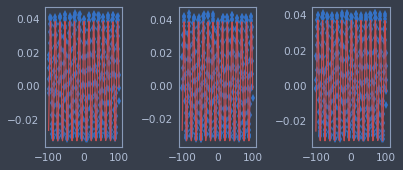

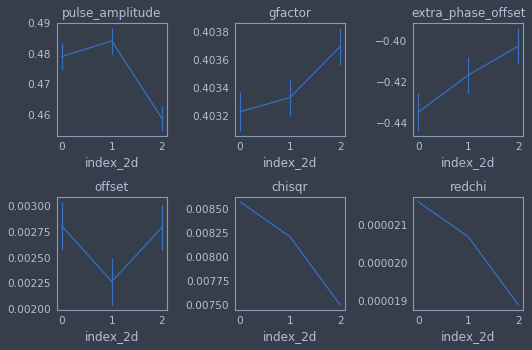

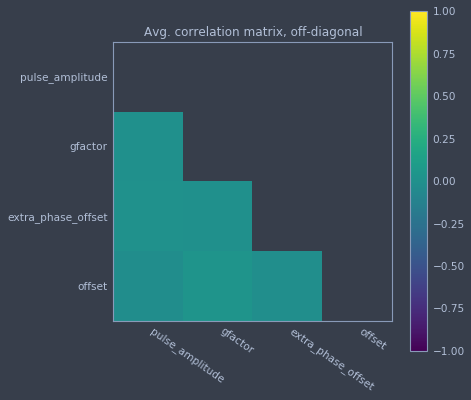

In [24]:
# REQUIRED: input filepaths
shared_filepath = ".//example_data//july2017_assorted_data//Field_Scan//"
dataframe_filepath = \
    shared_filepath + "processed_dataframe.csv"
metadata_list_filepath = \
    shared_filepath + "processed_metadata_list.json"
fit_results_dataframe_filepath = \
    shared_filepath + "fit_results_dataframe.csv"
fit_minimize_results_filepath = \
    shared_filepath + "fit_minimize_results.pickle"

# REQUIRED FOR PRE-FIT DATA: fit function & residuals
from eda.analysis.fit_tools import create_residuals_fcn
from eda.models.simple_dnp_trkr_rsa_simulation \
    import trkr_decaying_cosine
rsa_fit_function = trkr_decaying_cosine
rsa_fit_function_residuals = \
    create_residuals_fcn(trkr_decaying_cosine,
                         ['delay_time', 'total_bfield'])

# load data
with open(dataframe_filepath, 'r') as f:
    rsa_df = pd.read_csv(f, sep='\t',
                          index_col=['run_id', 'index_2d',
                                     'index_1d'])
with open(fit_results_dataframe_filepath, 'r') as f:
    rsa_fit_df = pd.read_csv(f, sep='\t',
                              index_col=['run_id', 'index_2d'])
with open(metadata_list_filepath, 'r') as f:
    rsa_file_metadata_list = json.load(f)
with open(fit_minimize_results_filepath, 'rb') as f:
    rsa_minimize_results = pickle.load(f)

# plot loaded dataframe and show the first few rows
figure_size = (FIG_SIZE_MULT * 3, FIG_SIZE_MULT * 1.5)
num_waterfall_plots = 4
measured_data_column = 'kerr_rotation'
x_values_column = 'b_external'
y_values_column = None
xlabel = 'External Magnetic Field (mT)'
ylabel = None
imshow_kwargs = {'aspect': 1.0,
                 'origin': 'upper'}
plt.figure(figsize=figure_size)
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
dfplot.plot_dataframe_colorplot(rsa_df, data_column,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=ylabel,
                                ax=ax1, **imshow_kwargs)
dfplot.plot_dataframe_waterfall(rsa_df, data_column,
                                num_waterfall_plots,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=None, ax=ax2)
ax2.yaxis.set_ticklabels([])
plt.show()
display(rsa_df.head(5))
print('...')
print('PREPROCESSED FIT RESULTS:')

# plot loaded fits
ncols = 4
nplots = len(rsa_minimize_results)
nrows = np.int(np.ceil(nplots / ncols))
display(rsa_fit_df.head(5))
plt.figure(figsize=(FIG_SIZE_MULT * 3, FIG_SIZE_MULT * nrows))
for result_index in list(range(nplots)):
    ax = plt.subplot(nrows, ncols, result_index + 1)
    result = rsa_minimize_results[result_index]
    dataset_index = rsa_fit_df.index[result_index]
    xvals = rsa_df.loc[dataset_index][x_values_column]
    yvals = rsa_df.loc[dataset_index][measured_data_column]
    fit_yvals = rsa_fit_function_residuals(
                    result.params,
                    rsa_df.loc[dataset_index].probe_delay,
                    rsa_df.loc[dataset_index].b_external)
    ax.plot(xvals, yvals, 'bd', label='dataset {}'.format(result_index))
    ax.plot(xvals, fit_yvals, 'r')
    plt.tight_layout()

# plot params
params_to_plot_list = \
    result.var_names + ['chisqr', 'redchi']
ncols = 3
nplots = len(params_to_plot_list)
nrows = np.int(np.ceil(nplots / ncols))
plt.figure(figsize=(FIG_SIZE_MULT * 3, FIG_SIZE_MULT * nrows))
for ind, param in enumerate(params_to_plot_list):
    ax = plt.subplot(nrows, ncols, ind + 1)
    if (param + '_error') in list(rsa_fit_df):
        ax.errorbar(x=rsa_fit_df.index.get_level_values(-1),
                    y=rsa_fit_df[param],
                    yerr=rsa_fit_df[param + '_error'])
    else:
        ax.plot(rsa_fit_df.index.get_level_values(-1),
                rsa_fit_df[param].values)
    plt.xlabel(rsa_fit_df.index.names[-1])
    plt.tight_layout()
    plt.title(param)

# plot the avg. covariance matrix
corr_mats = []
for result in rsa_minimize_results:
    covar = result.covar
    oostd = np.diagflat([1.0 / param.stderr
                         for param in list(result.params.values())
                         if param.name in result.var_names])
    corr = np.dot(np.dot(oostd, result.covar), oostd)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    corr[mask] = np.nan
    corr_mats.append(corr)
avgcorr = np.mean(corr_mats, axis=0)
plt.figure()
plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(np.arange(result.nvarys), result.var_names,
           rotation=-35, ha='left')
plt.yticks(np.arange(result.nvarys), result.var_names)
plt.title('Avg. correlation matrix, off-diagonal')
plt.show()